In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time

from IPython import display
import glob
!pip install imageio
import imageio
import os
from PIL import Image
import random

import tensorflow as tf
#import tensorflow_gan as tfgan
img_shape = (64, 64)


You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
data = []
for dirname, _, filenames in os.walk('/home/jovyan/work/GAN-Project/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data.append(np.asarray(Image.open(os.path.join(dirname, filename)).resize(img_shape)))
data = np.array(data)

/home/jovyan/work/GAN-Project/Data/anime_faces/1732_2001.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/62053_2019.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/59027_2018.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/59197_2018.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/43601_2013.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/50410_2015.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/52832_2016.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/45144_2014.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/17671_2007.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/1445_2001.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/49785_2015.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/38006_2012.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/38992_2012.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/28575_2010.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/47311_2014.jpg
/home/jovyan/work/GAN-Project/Data/anime_faces/57898_2017.jpg
/home/jovy

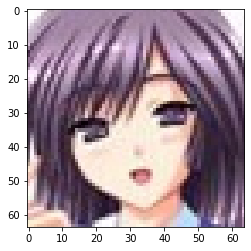

In [3]:
plt.imshow(data[100,:,:,:]) #, cmap = 'gray')

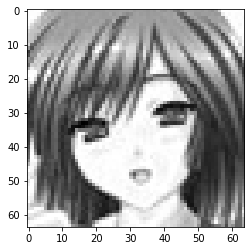

In [27]:
plt.imshow(data[100,:,:,0], cmap = 'gray')

In [4]:
data[100,:,:,:].shape

(64, 64, 3)

In [5]:
data.shape

(63565, 64, 64, 3)

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [7]:
"""
wasserstein_gradient_penalty
All losses must be able to accept 1D or 2D Tensors, so as to be compatible with
patchGAN style losses (https://arxiv.org/abs/1611.07004).
To make these losses usable in the TF-GAN framework, please create a tuple
version of the losses with `losses_utils.py`.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import tensorflow as tf
# from tensorflow_gan.python import contrib_utils as contrib


__all__ = [
    'acgan_discriminator_loss',
    'acgan_generator_loss',
    'least_squares_discriminator_loss',
    'least_squares_generator_loss',
    'modified_discriminator_loss',
    'modified_generator_loss',
    'minimax_discriminator_loss',
    'minimax_generator_loss',
    'wasserstein_discriminator_loss',
    'wasserstein_hinge_generator_loss',
    'wasserstein_hinge_discriminator_loss',
    'wasserstein_generator_loss',
    'wasserstein_gradient_penalty',
    'mutual_information_penalty',
    'combine_adversarial_loss',
    'cycle_consistency_loss',
]


def _to_float(tensor):
  return tf.cast(tensor, tf.float32)


# Wasserstein losses from `Wasserstein GAN` (https://arxiv.org/abs/1701.07875).
def wasserstein_generator_loss(
    discriminator_gen_outputs,
    weights=1.0,
    scope=None,
    loss_collection=tf.compat.v1.GraphKeys.LOSSES,
    reduction=tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
    add_summaries=False):
  """Wasserstein generator loss for GANs.
  See `Wasserstein GAN` (https://arxiv.org/abs/1701.07875) for more details.
  Args:
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
    weights: Optional `Tensor` whose rank is either 0, or the same rank as
      `discriminator_gen_outputs`, and must be broadcastable to
      `discriminator_gen_outputs` (i.e., all dimensions must be either `1`, or
      the same as the corresponding dimension).
    scope: The scope for the operations performed in computing the loss.
    loss_collection: collection to which this loss will be added.
    reduction: A `tf.losses.Reduction` to apply to loss.
    add_summaries: Whether or not to add detailed summaries for the loss.
  Returns:
    A loss Tensor. The shape depends on `reduction`.
  """
  with tf.compat.v1.name_scope(scope, 'generator_wasserstein_loss',
                               (discriminator_gen_outputs, weights)) as scope:
    discriminator_gen_outputs = _to_float(discriminator_gen_outputs)

    loss = - discriminator_gen_outputs
    loss = tf.compat.v1.losses.compute_weighted_loss(loss, weights, scope,
                                                     loss_collection, reduction)

    if add_summaries:
      tf.compat.v1.summary.scalar('generator_wass_loss', loss)

  return loss


def wasserstein_discriminator_loss(
    discriminator_real_outputs,
    discriminator_gen_outputs,
    real_weights=1.0,
    generated_weights=1.0,
    scope=None,
    loss_collection=tf.compat.v1.GraphKeys.LOSSES,
    reduction=tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
    add_summaries=False):
  """Wasserstein discriminator loss for GANs.
  See `Wasserstein GAN` (https://arxiv.org/abs/1701.07875) for more details.
  Args:
    discriminator_real_outputs: Discriminator output on real data.
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
    real_weights: Optional `Tensor` whose rank is either 0, or the same rank as
      `discriminator_real_outputs`, and must be broadcastable to
      `discriminator_real_outputs` (i.e., all dimensions must be either `1`, or
      the same as the corresponding dimension).
    generated_weights: Same as `real_weights`, but for
      `discriminator_gen_outputs`.
    scope: The scope for the operations performed in computing the loss.
    loss_collection: collection to which this loss will be added.
    reduction: A `tf.losses.Reduction` to apply to loss.
    add_summaries: Whether or not to add summaries for the loss.
  Returns:
    A loss Tensor. The shape depends on `reduction`.
  """
  with tf.compat.v1.name_scope(
      scope, 'discriminator_wasserstein_loss',
      (discriminator_real_outputs, discriminator_gen_outputs, real_weights,
       generated_weights)) as scope:
    discriminator_real_outputs = _to_float(discriminator_real_outputs)
    discriminator_gen_outputs = _to_float(discriminator_gen_outputs)
    discriminator_real_outputs.shape.assert_is_compatible_with(
        discriminator_gen_outputs.shape)

    loss_on_generated = tf.compat.v1.losses.compute_weighted_loss(
        discriminator_gen_outputs,
        generated_weights,
        scope,
        loss_collection=None,
        reduction=reduction)
    loss_on_real = tf.compat.v1.losses.compute_weighted_loss(
        discriminator_real_outputs,
        real_weights,
        scope,
        loss_collection=None,
        reduction=reduction)
    loss = loss_on_generated - loss_on_real
    tf.compat.v1.losses.add_loss(loss, loss_collection)

    if add_summaries:
      tf.compat.v1.summary.scalar('discriminator_gen_wass_loss',
                                  loss_on_generated)
      tf.compat.v1.summary.scalar('discriminator_real_wass_loss', loss_on_real)
      tf.compat.v1.summary.scalar('discriminator_wass_loss', loss)

  return loss


In [8]:
def D_loss(D_real, D_fake):
    -tf.reduce_mean(tf.math.log(D_real) + tf.math.log(1. - D_fake))

def G_loss(D_fake):
    return -tf.reduce_mean(tf.math.log(D_fake))

In [9]:
class GAN(object):
    def __init__(self, data = data, noise_shape = 1000, batch_size = 256, buffer_size = 60000, generator_loss = generator_loss, discriminator_loss = discriminator_loss, discriminator_type = 'discriminator'):
        
        """Wasserstein discriminator loss for GANs.

  Args:
    data: dataset that GAN is supposed to learn to mimic
    noise_shape: size of the array that will be the GAN input
    batch_size: size of data batch that will be calculated in one step of training 
    buffer_size: A tf.int64 scalar tf.Tensor, representing the number of elements 
                        from this dataset from which the new dataset will sample.
    generator_loss: function that will represent ghow good generator is
    discriminator_loss: function that will represent how good discriminator is
    discriminator_type: default "discriminator" means that GAN will be trained 
                        in default settings with basic loss functions. If you want to use 
                        wasserstein loss, this value should be changed to "critique". 
  """ 
        
        self.generator = tf.keras.models.Sequential()
        self.discriminator = tf.keras.models.Sequential()
        self.data = (data  - 127.5) / 127.5
        self.data_dimensions = data.shape[3]

        self.noise_shape = noise_shape
        self.BUFFER_SIZE = buffer_size
        self.BATCH_SIZE = batch_size
        self.data = tf.data.Dataset.from_tensor_slices(self.data).shuffle(self.BUFFER_SIZE).batch(self.BATCH_SIZE, drop_remainder = True)
        
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        
        self.loss = None

        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)
        self.num_examples_to_generate = 16

        # We will reuse this seed overtime (so it's easier)
        # to visualize progress in the animated GIF)
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_shape])

        self.create_generator()
        if discriminator_type == 'discriminator':
            self.create_discriminator()
    
    def create_generator(self):
        """
        function that creates model that is supposed to trick 
        our judge that his generated output is real image
        """
        self.generator.add(tf.keras.layers.Dense(512*4*4, use_bias=False, input_shape=(self.noise_shape,)))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())
        self.generator.add(tf.keras.layers.Reshape((4, 4, 512)))
        #assert self.generator.output_shape == (None, 7, 7, 512)
        
        self.generator.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert self.generator.output_shape == (None, 8, 8, 256)
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        self.generator.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert self.generator.output_shape == (None, 16, 16, 128)
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        
        self.generator.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert self.generator.output_shape == (None, 32, 32, 64)
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        self.generator.add(tf.keras.layers.Conv2DTranspose(self.data_dimensions, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert self.generator.output_shape == (None, 64, 64, self.data_dimensions)
        tf.keras.utils.plot_model(self.generator, to_file = 'generator.png')
        
    def create_discriminator(self, out_activation = 'sigmoid'):
        """
        depending on loss function, judge works like discriminator, or like critique
        """
        self.discriminator.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, self.data_dimensions]))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))

        self.discriminator.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))

        self.discriminator.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))

        
        # self.discriminator.add(tf.keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
        # self.discriminator.add(tf.keras.layers.LeakyReLU())
        # self.discriminator.add(tf.keras.layers.Dropout(0.3))

        self.discriminator.add(tf.keras.layers.Flatten())
        self.discriminator.add(tf.keras.layers.Dense(1)) #, activation = out_activation))
        tf.keras.utils.plot_model(self.discriminator, to_file = 'discriminator.png')
    
    def generate_and_save_images(self, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = self.generator(test_input, training=False)
        # predictions = random.choices(self.generated_images, k=self.num_examples_to_generate)
        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            if self.data_dimensions == 1:
                plt.imshow(predictions[i,:,:,0]* 127.5 + 127.5, cmap = 'gray')
            else:
                plt.imshow(predictions[i,:,:,:]* 127.5 + 127.5)
            plt.axis('off')

        plt.savefig('/home/jovyan/work/GAN-Project/epochs_images/image_at_epoch_{:04d}.png'.format(epoch))
        print(self.loss)
        plt.show()


    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_shape])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            self.loss = [gen_loss, disc_loss]

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def train(self, epochs):
        for epoch in range(epochs):
            start = time.time()
            self.generated_images = []
            for image_batch in self.data:
                self.train_step(image_batch)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            self.generate_and_save_images(epoch + 1,
                                        self.seed)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                self.checkpoint.save(file_prefix = self.checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        self.generate_and_save_images(epochs,self.seed)

In [10]:
gan = GAN(data = data[:,:,:,2].reshape(data.shape[0],data.shape[1],data.shape[2],1), noise_shape=128, discriminator_loss = discriminator_loss, generator_loss = generator_loss, discriminator_type='discriminator')
# gan = GAN(noise_shape=100, discriminator_loss = wasserstein_discriminator_loss, generator_loss = generator_loss)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


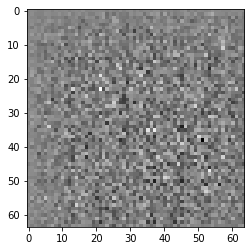

In [12]:
noise = tf.random.normal([256, 128])
generated_images = gan.generator(noise, training=False)
#print(generated_images[0])

plt.imshow(generated_images[0,:,:,0]* 127.5 + 127.5, cmap = 'gray')


In [13]:
for image_batch in gan.data:
    D_fake = gan.discriminator(image_batch)
    break
D_true = gan.discriminator(generated_images)

In [14]:
D_fake

<tf.Tensor: shape=(256, 1), dtype=float32, numpy=
array([[-2.62284484e-02],
       [ 1.55050894e-02],
       [-2.24078260e-02],
       [-2.18204726e-02],
       [ 4.20522876e-04],
       [ 4.36273776e-03],
       [ 2.07951739e-02],
       [ 2.31372789e-02],
       [ 1.77093316e-02],
       [-4.12709313e-03],
       [-2.29394976e-02],
       [-3.15474980e-02],
       [ 4.50067502e-03],
       [-1.49976332e-02],
       [ 4.05344889e-02],
       [-1.85602680e-02],
       [ 5.83504979e-03],
       [ 8.85965023e-03],
       [-1.98859093e-03],
       [-1.23702325e-02],
       [ 1.33115873e-02],
       [-4.86811325e-02],
       [-3.18778269e-02],
       [ 1.18788229e-02],
       [ 4.92143212e-03],
       [ 6.19299524e-03],
       [ 1.12313163e-02],
       [ 2.28174347e-02],
       [ 4.84176446e-04],
       [ 4.86027524e-02],
       [-3.18874754e-02],
       [-1.26217715e-02],
       [ 2.36504581e-02],
       [ 4.93688136e-03],
       [ 1.77775547e-02],
       [ 2.39529870e-02],
       [ 1.745

In [16]:
generator_loss(D_true)

<tf.Tensor: shape=(), dtype=float32, numpy=0.69322324>

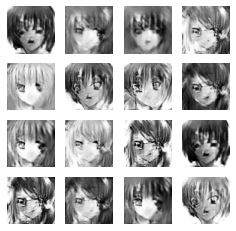

Time for epoch 500 is 72.8806540966034 sec


In [22]:
try:
    gan.train(500)
except:
    print('dupa')

[<tf.Tensor 'binary_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, <tf.Tensor 'add:0' shape=() dtype=float32>]


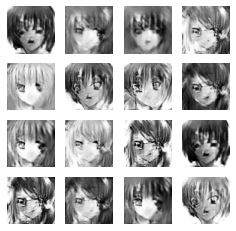

In [23]:
gan.generate_and_save_images(500, gan.seed)

In [24]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [25]:
anim_file = 'dcgan_second_train.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/home/jovyan/work/GAN-Project/epochs_images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)


In [26]:
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)